Dieses Notebook Erstellt die Visualisierung für den Anteil der Artefaktfenster in Abhängigkeit des Overlap Thresholds beim Labeln.

In [1]:
import sys
sys.path.append('../03 - Training')

import h5py
from utils.labeling import label_all_files

window_size_sec = 1.0
window_overlap = 0.0
overlap_tresholds = [0.99]
dir_path = "../../../../tuar_processed"
hdf5_path = "../03 - Training/features/features.hdf5"

for overlap_treshold in overlap_tresholds:
    label_generator = label_all_files(dir_path, window_size_sec, window_overlap, overlap_treshold)

    with h5py.File(hdf5_path, 'a') as hdf5_file:
        for session, label_dict in label_generator:
            session_group = hdf5_file.require_group(session)

            for channel, (data, labels) in label_dict.items():
                channel_group = session_group.require_group(channel)

                if f'labels_{overlap_treshold}_treshold' in channel_group:
                    del channel_group[f'labels_{overlap_treshold}_treshold']

                channel_group.create_dataset(f'labels_{overlap_treshold}_treshold', data=labels, compression="gzip", shuffle=True, chunks=True)

Labeling files in ../../../../tuar_processed: 0it [00:00, ?it/s]
Labeling files in ../../../../tuar_processed/train: 100%|██████████| 320/320 [00:36<00:00,  8.70it/s]
Labeling files in ../../../../tuar_processed/val: 100%|██████████| 98/98 [00:09<00:00, 10.39it/s]
Labeling files in ../../../../tuar_processed/test: 100%|██████████| 118/118 [00:12<00:00,  9.65it/s]


In [3]:
from utils.training import get_features_and_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib
import numpy as np


labels = [f'labels_{threshold}_treshold' for threshold in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]]
split_test = 'test'
split_train = 'train'
feature_file = "../03 - Training/features/features.hdf5"
data_split_file = "../03 - Training/data_split.yaml"
importance_path = '../03 - Training/output/exp_03_12_feature_importance.joblib'
features = None

top_n_features = 25
importance = joblib.load(importance_path)
top_n_features_idx = np.flip(np.argsort(importance['importances_mean']))[:25]

random_state = 42
max_depth = 25
class_weight = 'balanced'

macro_f1_scores = []
non_artifact_f1_scores = []
artifact_f1_scores = []

for label in labels:
    X_train, y_train = get_features_and_labels(feature_file, features, split_train, data_split_file, label)
    X_train = X_train[:, top_n_features_idx]

    X_test, y_test = get_features_and_labels(feature_file, features, split_test, data_split_file, label)
    X_test = X_test[:, top_n_features_idx]

    clf = RandomForestClassifier(n_jobs=-1, class_weight=class_weight, max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    macro_f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    artifact_f1_scores.append(f1_score(y_test, y_pred))
    non_artifact_f1_scores.append(f1_score(y_test, y_pred, pos_label=0))
score_dict = {
    'macro': macro_f1_scores,
    'artifact': artifact_f1_scores,
    'non-artifact': non_artifact_f1_scores
}

joblib.dump(score_dict, 'output/exp_04_02_overlap_f1_scores.joblib')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:02<00:00, 116.91it/s]


['output/exp_04_02_overlap_f1_scores.joblib']

In [6]:
import numpy as np

labels = [f'labels_{threshold}_treshold' for threshold in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]]
split_train = 'train'
split_val = 'val'
split_test = 'test'
feature_file = '../03 - Training/features/features.hdf5'
data_split_file = '../03 - Training/data_split.yaml'

total_set_proportion = []
artifact_counts = []

for label in labels:
    _, y_train = get_features_and_labels(feature_file, None, split_train, data_split_file, label_str=label)
    _, y_val = get_features_and_labels(feature_file, None, split_val, data_split_file, label_str=label)
    _, y_test = get_features_and_labels(feature_file, None, split_test, data_split_file, label_str=label)

    train_set_true_count = np.sum(y_train)
    train_set_total_count = len(y_train)
    val_set_true_count = np.sum(y_val)
    val_set_total_count = len(y_val)
    test_set_true_count = np.sum(y_test)
    test_set_total_count = len(y_test)

    # Pad labels with zeros to then count artifacts with diff
    padded_y_train = np.concatenate(([0], y_train, [0]))
    padded_y_val = np.concatenate(([0], y_val, [0]))
    padded_y_test = np.concatenate(([0], y_test, [0]))

    artifact_counts_train = np.sum(np.diff(padded_y_train) == 1)
    artifact_counts_val = np.sum(np.diff(padded_y_val) == 1)
    artifact_counts_test = np.sum(np.diff(padded_y_test) == 1)

    artifact_counts.append(artifact_counts_train + artifact_counts_val + artifact_counts_test)
    total_set_proportion.append((train_set_true_count + val_set_true_count + test_set_true_count) / (train_set_total_count + val_set_total_count + test_set_total_count))

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:01<00:00, 137.05it/s]


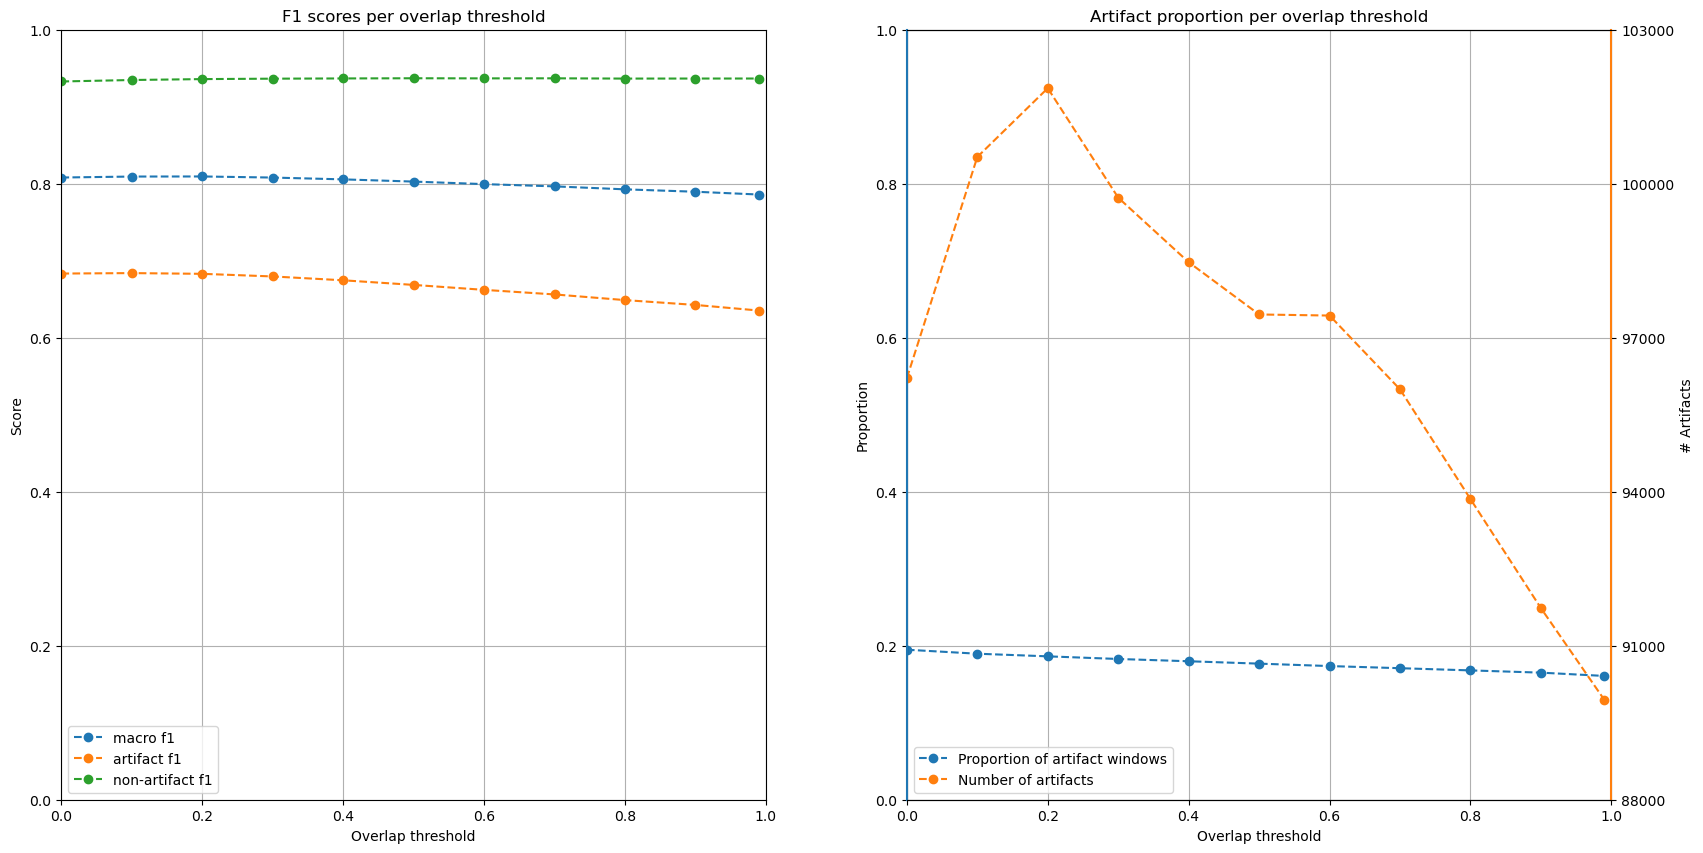

In [45]:
import joblib
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker

scores_dict = joblib.load('output/exp_04_02_overlap_f1_scores.joblib')
overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(overlaps, scores_dict['macro'], label='macro f1', marker='o', linestyle='--')
axes[0].plot(overlaps, scores_dict['artifact'], label='artifact f1', marker='o', linestyle='--')
axes[0].plot(overlaps, scores_dict['non-artifact'], label='non-artifact f1', marker='o', linestyle='--')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].grid(True)
axes[0].set_xlabel('Overlap threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('F1 scores per overlap threshold')
axes[0].legend(loc='lower left')

line1 = axes[1].plot(overlaps, total_set_proportion, label='Proportion of artifact windows', marker='o', linestyle='--')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].grid(True)
axes[1].set_xlabel('Overlap threshold')
axes[1].set_ylabel('Proportion')
axes[1].set_title('Artifact proportion per overlap threshold')

ax_art_count = axes[1].twinx()
line2 = ax_art_count.plot(overlaps, artifact_counts, label='Number of artifacts', marker='o', linestyle='--', color='tab:orange')
ax_art_count.set_ylabel('# Artifacts')
ax_art_count.yaxis.set_major_locator(ticker.LinearLocator(6))
ax_art_count.set_ylim(88000, 103000)

labels = [l.get_label() for l in line1 + line2]
axes[1].legend(line1 + line2, labels, loc='lower left')
ax_art_count.spines['left'].set_color('tab:blue')
ax_art_count.spines['left'].set_linewidth(1.5)
ax_art_count.spines['right'].set_color('tab:orange')
ax_art_count.spines['right'].set_linewidth(1.5)

fig.savefig('output/exp_04_02_overlap_f1_scores.pdf', bbox_inches='tight')
fig.show()